In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import os

In [3]:
csv_files = ['ICUDatasetProcessed/Attack.csv', 
             'ICUDatasetProcessed/environmentMonitoring.csv', 
             'ICUDatasetProcessed/patientMonitoring.csv']

dfs = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(dfs, ignore_index=True)
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)
shuffled_df.to_csv('shuffled_data.csv', index=False)

/var/folders/98/0wztx0n16mjcz88c4zsmx0dr0000gn/T/ipykernel_1291/2883848650.py:5: DtypeWarning: Columns (26,28,35) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(file) for file in csv_files]
/var/folders/98/0wztx0n16mjcz88c4zsmx0dr0000gn/T/ipykernel_1291/2883848650.py:5: DtypeWarning: Columns (26,28,35) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(file) for file in csv_files]


In [4]:
df = pd.read_csv('shuffled_data.csv')
df

,frame.time_delta,frame.time_relative,frame.len,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.flags,tcp.time_delta,tcp.len,...,mqtt.qos,mqtt.retain,mqtt.topic,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,class,label
0,0.970781,104.130101,62,192.168.1.90,192.168.1.91,50226,1883,0x00000018,0.970781,8,...,0.0,0.0,#,1.0,0.0,0.0,6,64,Attack,1
1,0.000055,585.824957,79,10.5.126.137,10.5.126.84,38017,1883,0x00000018,2.996567,11,...,1.0,0.0,Fire,4.0,0.0,0.0,6,64,environmentMonitoring,0
2,0.000030,3033.031683,86,10.5.126.168,10.5.126.56,36849,1883,0x00000018,2.002304,18,...,0.0,0.0,Pulsoximeter,12.0,0.0,0.0,6,64,patientMonitoring,0
3,0.000243,0.241203,69,10.16.120.44,10.16.120.72,57546,1883,0x00000018,0.000346,3,...,0.0,0.0,0.0,0.0,4.0,0.0,6,64,Attack,1
4,0.000019,0.569820,74,10.16.120.72,10.16.120.44,1883,58904,0x00000012,0.000019,0,...,0.0,0.0,0.0,0.0,0.0,0.0,6,64,Attack,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188689,0.000058,4390.030002,86,10.5.126.148,10.5.126.56,37701,1883,0x00000018,1.983694,18,...,0.0,0.0,Pulsoximeter,12.0,0.0,0.0,6,64,patientMonitoring,0
188690,0.000293,62.762020,60,192.168.1.91,192.168.1.90,1883,54546,0x00000018,0.000293,4,...,0.0,0.0,0,0.0,0.0,0.0,6,128,Attack,1
188691,0.000001,15.853036,152,192.168.1.90,192.168.1.91,54542,1883,0x00000018,0.000001,98,...,1.0,0.0,mqtt-malaria/beem.loadr-MBP-di-Ivan-5.lan-5476...,65.0,0.0,0.0,6,64,Attack,1
188692,0.000034,13.233742,223,192.168.1.90,192.168.1.91,54542,1883,0x00000018,0.000034,169,...,1.0,0.0,mqtt-malaria/beem.loadr-MBP-di-Ivan-5.lan-5476...,65.0,0.0,0.0,6,64,Attack,1


In [5]:
relevant_columns = [
    'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.ack', 'tcp.window_size_value',
    'tcp.connection.fin', 'tcp.connection.syn', 'tcp.connection.rst', 'tcp.payload',
    'ip.src', 'ip.dst', 'ip.proto', 'ip.ttl', 'mqtt.clientid', 'mqtt.msgtype',
    'mqtt.topic', 'mqtt.kalive', 'mqtt.len', 'mqtt.qos', 'tcp.checksum',
    'tcp.hdr_len', 'frame.time_delta', 'frame.time_relative', 'tcp.time_delta', 'label'
]

In [6]:
df = df[relevant_columns]

In [7]:
df['tcp.checksum'] = df['tcp.checksum'].apply(lambda x: int(x, 16))


/var/folders/98/0wztx0n16mjcz88c4zsmx0dr0000gn/T/ipykernel_1291/2897899658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tcp.checksum'] = df['tcp.checksum'].apply(lambda x: int(x, 16))


In [8]:
def get_payload_length(payload):
    try:
        payload_clean = ''.join(c for c in payload if c in '0123456789ABCDEFabcdef')
        if not payload_clean:
            return 0
        byte_data = bytes.fromhex(payload_clean)
        return len(byte_data)
    except ValueError:
        return 0

df['payload_length'] = df['tcp.payload'].apply(get_payload_length)
df.drop('tcp.payload', axis=1,  inplace=True)

/var/folders/98/0wztx0n16mjcz88c4zsmx0dr0000gn/T/ipykernel_1291/1462820416.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['payload_length'] = df['tcp.payload'].apply(get_payload_length)
/var/folders/98/0wztx0n16mjcz88c4zsmx0dr0000gn/T/ipykernel_1291/1462820416.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('tcp.payload', axis=1,  inplace=True)


In [9]:
categorial_df=df.select_dtypes(include="object")
for col in categorial_df.columns:
    print(col, ":", len(df[col].unique()), "labels")

tcp.flags : 8 labels
ip.src : 44 labels
ip.dst : 44 labels
mqtt.clientid : 1158 labels
mqtt.topic : 23440 labels


In [10]:
df['label'].value_counts()

label
0    108568
1     80126
Name: count, dtype: int64

In [11]:
df

,tcp.srcport,tcp.dstport,tcp.flags,tcp.ack,tcp.window_size_value,tcp.connection.fin,tcp.connection.syn,tcp.connection.rst,ip.src,ip.dst,...,mqtt.kalive,mqtt.len,mqtt.qos,tcp.checksum,tcp.hdr_len,frame.time_delta,frame.time_relative,tcp.time_delta,label,payload_length
0,50226,1883,0x00000018,5,4096,0.0,0.0,0.0,192.168.1.90,192.168.1.91,...,0.0,6.0,0.0,42464,20,0.970781,104.130101,0.970781,1,8
1,38017,1883,0x00000018,803,512,0.0,0.0,0.0,10.5.126.137,10.5.126.84,...,0.0,9.0,1.0,4377,32,0.000055,585.824957,2.996567,0,11
2,36849,1883,0x00000018,105,512,0.0,0.0,0.0,10.5.126.168,10.5.126.56,...,0.0,16.0,0.0,4387,32,0.000030,3033.031683,2.002304,0,18
3,57546,1883,0x00000018,1,229,0.0,0.0,0.0,10.16.120.44,10.16.120.72,...,65535.0,30.0,0.0,30954,32,0.000243,0.241203,0.000346,1,3
4,1883,58904,0x00000012,1,28960,0.0,0.0,0.0,10.16.120.72,10.16.120.44,...,0.0,0.0,0.0,47792,40,0.000019,0.569820,0.000019,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188689,37701,1883,0x00000018,151,512,0.0,0.0,0.0,10.5.126.148,10.5.126.56,...,0.0,16.0,0.0,4367,32,0.000058,4390.030002,1.983694,0,18
188690,1883,54546,0x00000018,919290,513,0.0,0.0,0.0,192.168.1.91,192.168.1.90,...,0.0,2.0,0.0,50392,20,0.000293,62.762020,0.000293,1,4
188691,54542,1883,0x00000018,22533,4096,0.0,0.0,0.0,192.168.1.90,192.168.1.91,...,0.0,168.0,1.0,13321,20,0.000001,15.853036,0.000001,1,98
188692,54542,1883,0x00000018,15853,4095,0.0,0.0,0.0,192.168.1.90,192.168.1.91,...,0.0,166.0,1.0,65118,20,0.000034,13.233742,0.000034,1,169


In [12]:
from sklearn.preprocessing  import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
df_encoded = df.copy()

print(df_encoded)

        tcp.srcport  tcp.dstport   tcp.flags  tcp.ack  tcp.window_size_value  \
0             50226         1883  0x00000018        5                   4096   
1             38017         1883  0x00000018      803                    512   
2             36849         1883  0x00000018      105                    512   
3             57546         1883  0x00000018        1                    229   
4              1883        58904  0x00000012        1                  28960   
...             ...          ...         ...      ...                    ...   
188689        37701         1883  0x00000018      151                    512   
188690         1883        54546  0x00000018   919290                    513   
188691        54542         1883  0x00000018    22533                   4096   
188692        54542         1883  0x00000018    15853                   4095   
188693        33251         1883  0x00000018      139                    512   

        tcp.connection.fin  tcp.connect

In [14]:
X = df_encoded.drop('label', axis=1)
print(X.dtypes)
encoder = OrdinalEncoder()
X[X.columns] = encoder.fit_transform(X)
y = df_encoded['label']

tcp.srcport                int64
tcp.dstport                int64
tcp.flags                 object
tcp.ack                    int64
tcp.window_size_value      int64
tcp.connection.fin       float64
tcp.connection.syn       float64
tcp.connection.rst       float64
ip.src                    object
ip.dst                    object
ip.proto                   int64
ip.ttl                     int64
mqtt.clientid             object
mqtt.msgtype             float64
mqtt.topic                object
mqtt.kalive              float64
mqtt.len                 float64
mqtt.qos                 float64
tcp.checksum               int64
tcp.hdr_len                int64
frame.time_delta         float64
frame.time_relative      float64
tcp.time_delta           float64
payload_length             int64
dtype: object


In [15]:
X.dtypes

tcp.srcport              float64
tcp.dstport              float64
tcp.flags                float64
tcp.ack                  float64
tcp.window_size_value    float64
tcp.connection.fin       float64
tcp.connection.syn       float64
tcp.connection.rst       float64
ip.src                   float64
ip.dst                   float64
ip.proto                 float64
ip.ttl                   float64
mqtt.clientid            float64
mqtt.msgtype             float64
mqtt.topic               float64
mqtt.kalive              float64
mqtt.len                 float64
mqtt.qos                 float64
tcp.checksum             float64
tcp.hdr_len              float64
frame.time_delta         float64
frame.time_relative      float64
tcp.time_delta           float64
payload_length           float64
dtype: object

In [16]:
X.columns

Index(['tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.ack',
       'tcp.window_size_value', 'tcp.connection.fin', 'tcp.connection.syn',
       'tcp.connection.rst', 'ip.src', 'ip.dst', 'ip.proto', 'ip.ttl',
       'mqtt.clientid', 'mqtt.msgtype', 'mqtt.topic', 'mqtt.kalive',
       'mqtt.len', 'mqtt.qos', 'tcp.checksum', 'tcp.hdr_len',
       'frame.time_delta', 'frame.time_relative', 'tcp.time_delta',
       'payload_length'],
      dtype='object')

In [17]:
X_reshaped = X.values.reshape(X.shape[0], X.shape[1], 1)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [19]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, dt_pred)}')
print(classification_report(y_test,dt_pred, digits=6))

Accuracy: 0.9504849052270841
              precision    recall  f1-score   support

           0   0.920602  1.000000  0.958660     32500
           1   1.000000  0.883736  0.938280     24109

    accuracy                       0.950485     56609
   macro avg   0.960301  0.941868  0.948470     56609
weighted avg   0.954416  0.950485  0.949980     56609



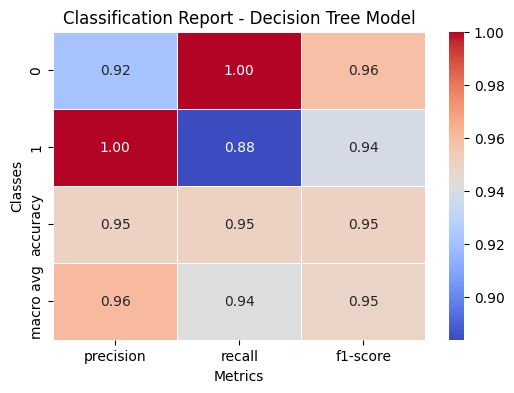

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# Train and predict using Decision Tree
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

# Generate classification report dictionary
report_dict = classification_report(y_test, dt_pred, output_dict=True)

# Convert to DataFrame and drop 'support' column
report_df = pd.DataFrame(report_dict).T.iloc[:-1, :-1]  # Remove 'accuracy' row and 'support' column

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(report_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Classification Report - Decision Tree Model")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()


In [36]:
confusion_matrix(y_test, dt_pred)

array([[32500,     0],
       [ 2803, 21306]])

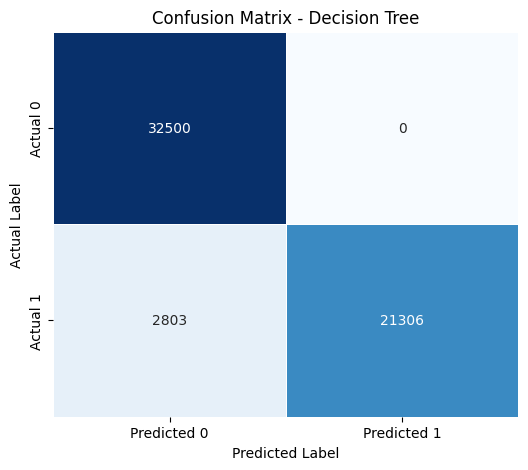

In [50]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define confusion matrix values
cm = np.array([[32500, 0],
               [2803, 21306]])

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], 
            yticklabels=["Actual 0", "Actual 1"], linewidths=0.5, cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()


In [37]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, xgb_pred)}')
print(classification_report(y_test,xgb_pred, digits=6))

Accuracy: 1.0
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000     32500
           1   1.000000  1.000000  1.000000     24109

    accuracy                       1.000000     56609
   macro avg   1.000000  1.000000  1.000000     56609
weighted avg   1.000000  1.000000  1.000000     56609



1770/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


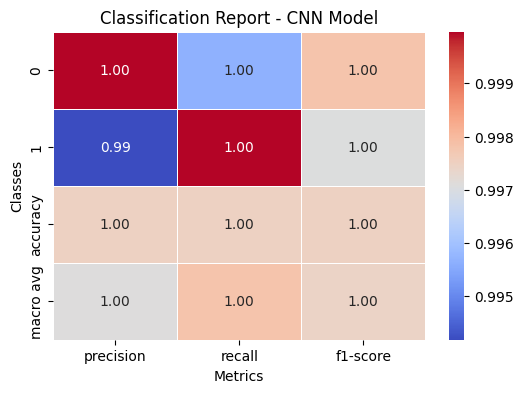

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# Generate classification report dictionary
cnn_pred = (model.predict(X_test) > 0.5).astype(int)  # Ensure binary predictions
report_dict = classification_report(y_test, cnn_pred, output_dict=True)

# Convert to DataFrame and drop 'support' column
report_df = pd.DataFrame(report_dict).T.iloc[:-1, :-1]  # Remove 'accuracy' row and support column

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(report_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Classification Report - CNN Model")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()


In [38]:
confusion_matrix(y_test, xgb_pred)

array([[32500,     0],
       [    0, 24109]])

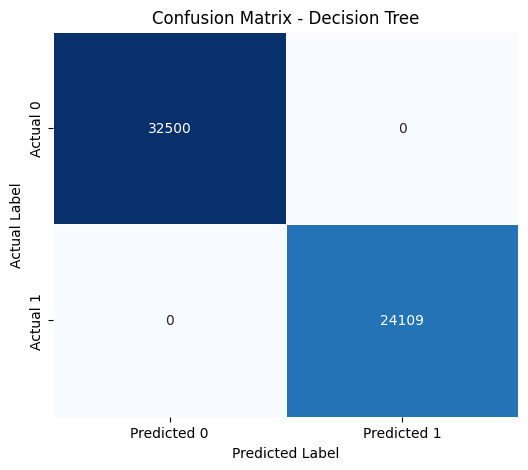

In [52]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define confusion matrix values
cm = np.array([[32500, 0],
               [0, 24109]])

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], 
            yticklabels=["Actual 0", "Actual 1"], linewidths=0.5, cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()


In [39]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [40]:
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.3, random_state=33)

In [41]:
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Users/laureltheodore/Desktop/drive-download-20250221T140014Z-001/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 3s 693us/step - accuracy: 0.9831 - loss: 7.2312 - val_accuracy: 0.9983 - val_loss: 0.1758
Epoch 2/5
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 3s 685us/step - accuracy: 0.9950 - loss: 0.7885 - val_accuracy: 0.9775 - val_loss: 1.5693
Epoch 3/5
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 3s 658us/step - accuracy: 0.9963 - loss: 0.4158 - val_accuracy: 0.9982 - val_loss: 0.1018
Epoch 4/5
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 3s 643us/step - accuracy: 0.9938 - loss: 0.1253 - val_accuracy: 0.9979 - val_loss: 0.0305
Epoch 5/5
4128/4128 ━━━━━━━━━━━━━━━━━━━━ 3s 649us/step - accuracy: 0.9920 - loss: 0.0370 - val_accuracy: 0.9975 - val_loss: 0.0120


In [44]:
cnn_pred = model.predict(X_test)>0.5
print(f'Accuracy: {accuracy_score(y_test, cnn_pred)}')
print(classification_report(y_test,cnn_pred, digits=6))

1770/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
Accuracy: 0.9974915649455034
              precision    recall  f1-score   support

           0   0.999969  0.995662  0.997811     32500
           1   0.994185  0.999959  0.997064     24109

    accuracy                       0.997492     56609
   macro avg   0.997077  0.997810  0.997437     56609
weighted avg   0.997506  0.997492  0.997492     56609



In [45]:
confusion_matrix(y_test, cnn_pred)

array([[32359,   141],
       [    1, 24108]])

In [46]:
combined_preds = np.array([xgb_pred.astype(int), np.squeeze(cnn_pred).astype(int), dt_pred.astype(int)])
final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=combined_preds)

# Step 4: Evaluate the model
accuracy = accuracy_score(y_test, final_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, final_preds, digits=6))

Accuracy: 100.00%
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000     32500
           1   1.000000  1.000000  1.000000     24109

    accuracy                       1.000000     56609
   macro avg   1.000000  1.000000  1.000000     56609
weighted avg   1.000000  1.000000  1.000000     56609



In [47]:
confusion_matrix(y_test, final_preds)

array([[32500,     0],
       [    0, 24109]])

In [48]:
import pickle

with open('models/xgb.pkl','wb') as f:
    pickle.dump(xgb, f)

with open('models/dt.pkl','wb') as f:
    pickle.dump(dt, f)

with open('models/encoder.pkl','wb') as f:
    pickle.dump(encoder, f)

model.save('models/cnn.h5')

1770/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


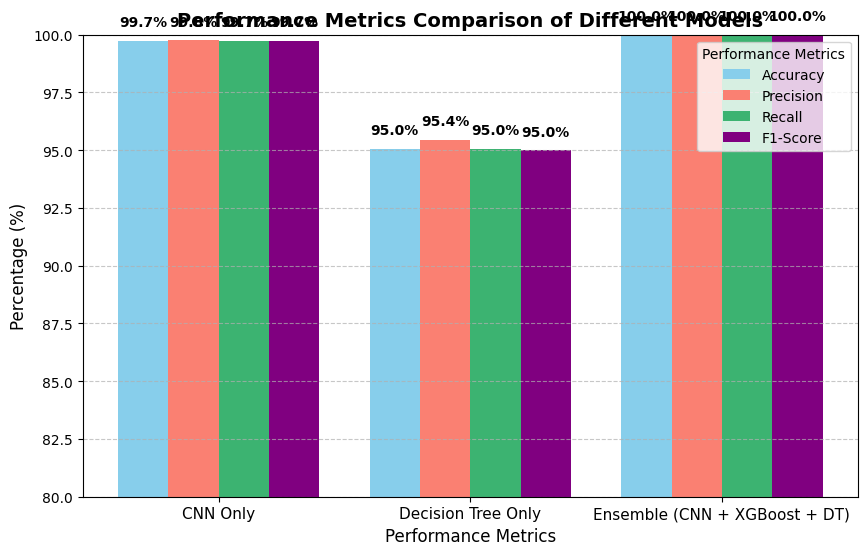

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get model predictions
y_pred_dt = dt.predict(X_test)  # Decision Tree Predictions
y_pred_xgb = xgb.predict(X_test)  # XGBoost Predictions
y_pred_cnn = (model.predict(X_test) > 0.5).astype(int).flatten()  # CNN Predictions

# Ensemble Model - Majority Voting
combined_preds = np.array([y_pred_xgb, y_pred_cnn, y_pred_dt])
final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=combined_preds)

# Define Model Names
models = ["CNN Only", "Decision Tree Only", "Ensemble (CNN + XGBoost + DT)"]

# Compute Performance Metrics
accuracy = [
    accuracy_score(y_test, y_pred_cnn) * 100,
    accuracy_score(y_test, y_pred_dt) * 100,
    accuracy_score(y_test, final_preds) * 100
]

precision = [
    precision_score(y_test, y_pred_cnn, average='weighted') * 100,
    precision_score(y_test, y_pred_dt, average='weighted') * 100,
    precision_score(y_test, final_preds, average='weighted') * 100
]

recall = [
    recall_score(y_test, y_pred_cnn, average='weighted') * 100,
    recall_score(y_test, y_pred_dt, average='weighted') * 100,
    recall_score(y_test, final_preds, average='weighted') * 100
]

f1_score_vals = [
    f1_score(y_test, y_pred_cnn, average='weighted') * 100,
    f1_score(y_test, y_pred_dt, average='weighted') * 100,
    f1_score(y_test, final_preds, average='weighted') * 100
]

# Convert to NumPy arrays
x = np.arange(len(models))  # Label locations
width = 0.2  # Bar width

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
bars1 = ax.bar(x - width*1.5, accuracy, width, label="Accuracy", color='skyblue')
bars2 = ax.bar(x - width/2, precision, width, label="Precision", color='salmon')
bars3 = ax.bar(x + width/2, recall, width, label="Recall", color='mediumseagreen')
bars4 = ax.bar(x + width*1.5, f1_score_vals, width, label="F1-Score", color='purple')

# Function to add percentage labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}%', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add labels to bars
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# Formatting the graph
ax.set_xlabel("Performance Metrics", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_title("Performance Metrics Comparison of Different Models", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.legend(title="Performance Metrics")
ax.set_ylim(80, 100)  # Y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
